In [1]:
__author__ = "elejke"

In [2]:
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
from __future__ import division
# math, computer vision and visualization libs:
import cv2
import h5py
import keras
import random
import datetime
import threading
import shapely.wkt
import numpy as np
import pandas as pd
import tifffile as tiff
import shapely.affinity
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import defaultdict
# keras lib and modules
from keras.models import Model
from keras import backend as K
from keras.callbacks import History
from keras.models import model_from_json
from keras.optimizers import Adam, Nadam
from keras.backend import binary_crossentropy
from keras.preprocessing.image import random_rotation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Cropping2D, concatenate
# our modules:
from data_handling import read_img, read_mask
from gdrive_download import download_file_from_google_drive

Using TensorFlow backend.


# Data loading:

In [5]:
DATA_DIR = "./data/"

DATA_DIR_V_TRAIN = os.path.join(DATA_DIR, "ventura_train")
DATA_DIR_V_TEST = os.path.join(DATA_DIR, "ventura_test")
DATA_DIR_SR_TRAIN = os.path.join(DATA_DIR, "santa_rosa_train")
DATA_DIR_SR_TEST = os.path.join(DATA_DIR, "santa_rosa_test")

In [6]:
# TAKE ID FROM SHAREABLE LINK
file_id = "1zNK1YV0kMzImtN1ypfMZWLHqBsGEzEKC"
# DESTINATION FILE ON YOUR DISK
destination_ = os.path.join(DATA_DIR, 'data_prepared.zip')
# download_file_from_google_drive(file_id, destination_)

In [7]:
# !cd ./data
# !unzip data_prepared.zip
# !rm

# Load some data:

In [8]:
img_ventura_train = read_img(DATA_DIR_V_TRAIN)
mask_ventura_train = read_mask(DATA_DIR_V_TRAIN)

# Image plotting:

In [9]:
def plot_image(img, mask):
    f, (axarr) = plt.subplots(1, 3, sharey=True, figsize=(60, 10))
    
    tiff.imshow(img[:3], figure=f, subplot=axarr[0], title="Before")
    tiff.imshow(img[3:], figure=f, subplot=axarr[1], title="After")
    axarr[2].imshow(mask)
    axarr[2].set_title("Mask")
    f.subplots_adjust(right=0.55)
    
    plt.show()

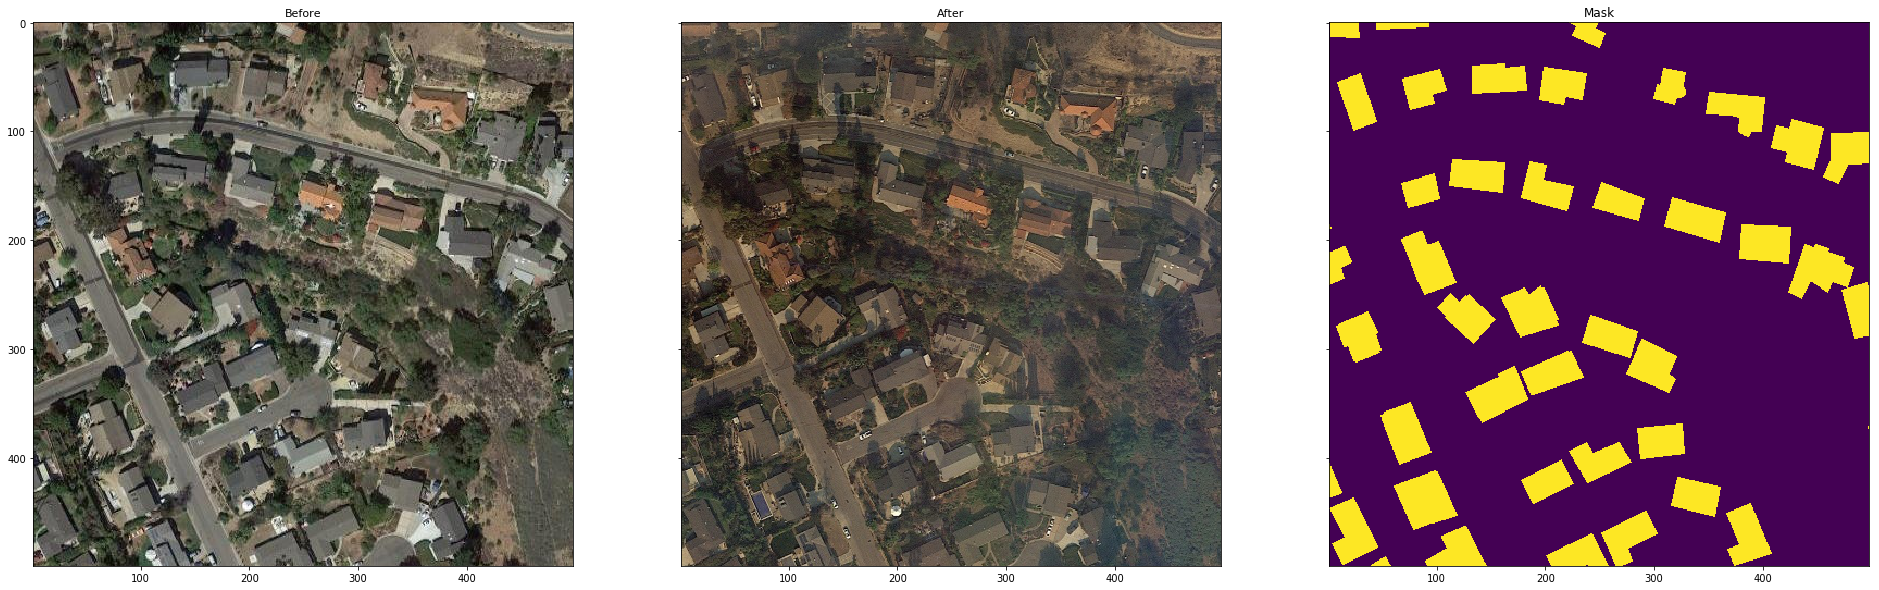

In [10]:
# some random part of training data:
plot_image(img_ventura_train[:, 1000 : 1500, 1000 : 1500], 
           mask_ventura_train[1000 : 1500, 1000 : 1500])

# Train simple model:

### U-net

In [11]:
from unet import get_unet

In [12]:
N_CLASSES = 1
N_CHANNELS = 6
IMG_SIZE = [1000, 1000]

In [13]:
model = get_unet(input_shape=IMG_SIZE + [N_CHANNELS], n_classes=N_CLASSES, n_filters=32)

In [14]:
# Compile the model:
model.compile(optimizer=Nadam(lr=1e-4), 
              loss=binary_crossentropy, 
              metrics=['binary_crossentropy'])

# Train network:

In [26]:
from generator import batch_generator

In [27]:
train_generator = batch_generator(image=img_ventura_train, mask=mask_ventura_train, batch_size=1)

In [28]:
val_generator = batch_generator(image=img_ventura_train, mask=mask_ventura_train, batch_size=1)

In [29]:
history = model.fit_generator(train_generator, 
                              steps_per_epoch=40,
                              epochs=5, 
                              verbose=1, 
                              validation_data=val_generator, 
                              validation_steps=10)

Epoch 1/5
40/40 [==============================] - 2s 52ms/step - loss: 0.4495 - binary_crossentropy: 0.4495 - val_loss: 0.5620 - val_binary_crossentropy: 0.5620
Epoch 2/5
40/40 [==============================] - 2s 48ms/step - loss: 0.4156 - binary_crossentropy: 0.4156 - val_loss: 0.4307 - val_binary_crossentropy: 0.4307
Epoch 3/5
40/40 [==============================] - 2s 48ms/step - loss: 0.3832 - binary_crossentropy: 0.3832 - val_loss: 0.5733 - val_binary_crossentropy: 0.5733
Epoch 4/5
40/40 [==============================] - 2s 49ms/step - loss: 0.3841 - binary_crossentropy: 0.3841 - val_loss: 0.4297 - val_binary_crossentropy: 0.4297
Epoch 5/5
40/40 [==============================] - 2s 50ms/step - loss: 0.3561 - binary_crossentropy: 0.3561 - val_loss: 0.4234 - val_binary_crossentropy: 0.4234


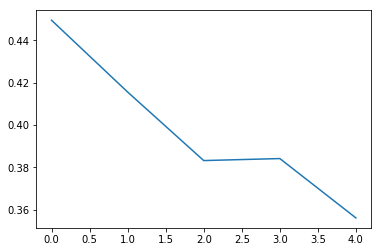

In [30]:
plt.plot(history.history["binary_crossentropy"])
plt.show()

# Model validation:

In [31]:
def plot_result(x_, y_, model):
    f, (axarr) = plt.subplots(1, 4, sharey=True, figsize=(45, 7))
    y_pred = model.predict(x_)
    
    tiff.imshow(x_[0, :, :, :3], figure=f, subplot=axarr[0], title="Image")
    tiff.imshow(y_[0], figure=f, subplot=axarr[1], title="Mask")
    tiff.imshow(y_pred[0], figure=f, subplot=axarr[2], title="Pred")
    tiff.imshow(y_[0] * y_pred[0], figure=f, subplot=axarr[3], title="Mask * Pred " + str(np.mean((y_[0] * y_pred[0]) / y_[0].mean())))            
    f.subplots_adjust(right=0.75)
    
    plt.show()

In [35]:
x_, y_ = next(val_generator)

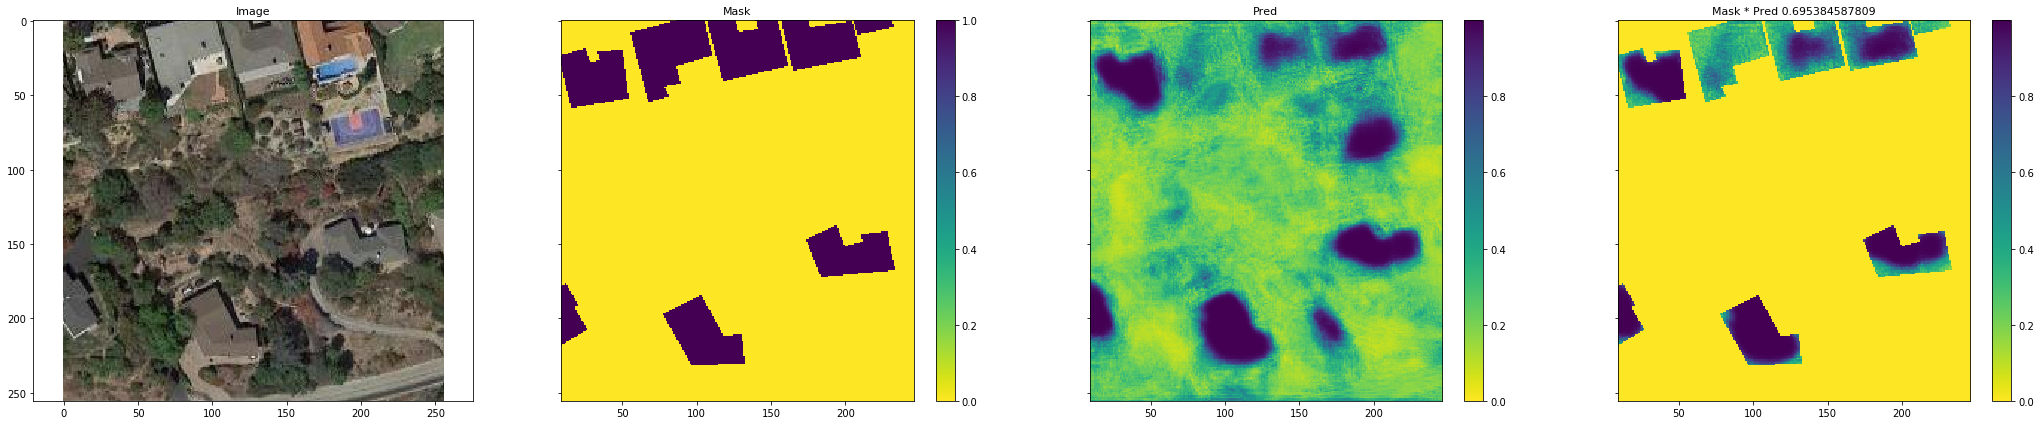

In [36]:
for img_n_ in range(len(x_[:])):
    plot_result(x_[img_n_ : img_n_ + 1], y_[img_n_ : img_n_ + 1], model)